### Antoine EDY
# Natural Language Processing (COMM061) - Coursework

In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
import torch
import nltk
from torch.utils.tensorboard import SummaryWriter

In [2]:
dataset = load_dataset("surrey-nlp/PLOD-CW")

In [3]:
TEXT2ID = {
    "B-O": 0,
    "B-AC": 1,
    "PAD": 2,
    "B-LF": 3,
    "I-LF": 4,
}
ID2TEXT = {v: k for k, v in TEXT2ID.items()}

print(f"TEXT2ID: {TEXT2ID}\nID2TEXT: {ID2TEXT}\n")

def preprocess(df):
    df = df.drop(columns=['pos_tags'])
    df = df.rename(columns={"ner_tags": "labels"})
    df["ids"] = df["labels"].apply(lambda x: [TEXT2ID[i] for i in x])
    df["sentences"] = df["tokens"].apply(lambda x: " ".join(x))

    return df


train_dataset = preprocess(pd.DataFrame(dataset['train']))
test_dataset = preprocess(pd.DataFrame(dataset['test']))
val_dataset = preprocess(pd.DataFrame(dataset['validation']))

train_dataset.info()


# Here the exploration to add at the end of the work.

TEXT2ID: {'B-O': 0, 'B-AC': 1, 'PAD': 2, 'B-LF': 3, 'I-LF': 4}
ID2TEXT: {0: 'B-O', 1: 'B-AC', 2: 'PAD', 3: 'B-LF', 4: 'I-LF'}

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1072 entries, 0 to 1071
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tokens     1072 non-null   object
 1   labels     1072 non-null   object
 2   ids        1072 non-null   object
 3   sentences  1072 non-null   object
dtypes: object(4)
memory usage: 33.6+ KB


In [4]:
train_dataset.head()

,tokens,labels,ids,sentences
0,"[For, this, purpose, the, Gothenburg, Young, P...","[B-O, B-O, B-O, B-O, B-LF, I-LF, I-LF, I-LF, I...","[0, 0, 0, 0, 3, 4, 4, 4, 4, 0, 1, 0, 0, 0, 0]",For this purpose the Gothenburg Young Persons ...
1,"[The, following, physiological, traits, were, ...","[B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-LF, I-LF...","[0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 1, 0, 0, 0, 0, ...",The following physiological traits were measur...
2,"[Minor, H, antigen, alloimmune, responses, rea...","[B-O, B-AC, B-O, B-O, B-O, B-O, B-O, B-O, B-O,...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 0, ...",Minor H antigen alloimmune responses readily o...
3,"[EPI, =, Echo, planar, imaging, .]","[B-AC, B-O, B-LF, I-LF, I-LF, B-O]","[1, 0, 3, 4, 4, 0]",EPI = Echo planar imaging .
4,"[Furthermore, ,, eNOS, -, derived, NO, S, -, n...","[B-O, B-O, B-AC, B-O, B-O, B-AC, B-O, B-O, B-O...","[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","Furthermore , eNOS - derived NO S - nitrosylat..."


In [5]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

1072
126
153


In [6]:
#tokenization

from transformers import BertTokenizer
# None for now!

In [7]:
train_dataset.head()

,tokens,labels,ids,sentences
0,"[For, this, purpose, the, Gothenburg, Young, P...","[B-O, B-O, B-O, B-O, B-LF, I-LF, I-LF, I-LF, I...","[0, 0, 0, 0, 3, 4, 4, 4, 4, 0, 1, 0, 0, 0, 0]",For this purpose the Gothenburg Young Persons ...
1,"[The, following, physiological, traits, were, ...","[B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-LF, I-LF...","[0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 1, 0, 0, 0, 0, ...",The following physiological traits were measur...
2,"[Minor, H, antigen, alloimmune, responses, rea...","[B-O, B-AC, B-O, B-O, B-O, B-O, B-O, B-O, B-O,...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 0, ...",Minor H antigen alloimmune responses readily o...
3,"[EPI, =, Echo, planar, imaging, .]","[B-AC, B-O, B-LF, I-LF, I-LF, B-O]","[1, 0, 3, 4, 4, 0]",EPI = Echo planar imaging .
4,"[Furthermore, ,, eNOS, -, derived, NO, S, -, n...","[B-O, B-O, B-AC, B-O, B-O, B-AC, B-O, B-O, B-O...","[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","Furthermore , eNOS - derived NO S - nitrosylat..."


In [8]:
from torchtext.data import Field, Dataset, Example

text_field = Field(sequential=True, tokenize=lambda x:x, include_lengths=True) # Default behaviour is to tokenize by splitting
label_field = Field(sequential=True, tokenize=lambda x:x, is_target=True)

fields = {
    'sentences': ('text', text_field),
    'ids': ('label', label_field)
}

def read_data(df):
    examples = []
    fields = {'sentence_labels': ('labels', label_field),
              'sentence_tokens': ('text', text_field)}
    
    for i in range(len(df)):
        tokens = df['tokens'][i]
        labels = df['labels'][i]
        
        e = Example.fromdict({"sentence_labels": labels, "sentence_tokens": tokens},
                             fields=fields)
        examples.append(e)
    
    return Dataset(examples, fields=[('labels', label_field), ('text', text_field)])


train_data = read_data(train_dataset)
val_data = read_data(val_dataset)
test_data = read_data(test_dataset)

print(train_data.fields)
print(train_data[0].text)
print(train_data[0].labels)

print("Train:", len(train_data))
print("Dev:", len(val_data))
print("Test:", len(test_data))

{'labels': <torchtext.data.field.Field object at 0x175287a30>, 'text': <torchtext.data.field.Field object at 0x175287a90>}
['For', 'this', 'purpose', 'the', 'Gothenburg', 'Young', 'Persons', 'Empowerment', 'Scale', '(', 'GYPES', ')', 'was', 'developed', '.']
['B-O', 'B-O', 'B-O', 'B-O', 'B-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'B-O', 'B-AC', 'B-O', 'B-O', 'B-O', 'B-O']
Train: 1072
Dev: 126
Test: 153


In [9]:
VOCAB_SIZE = 20000

text_field.build_vocab(train_data, max_size=VOCAB_SIZE)
label_field.build_vocab(train_data)

In [10]:
from torchtext.data import BucketIterator

BATCH_SIZE = 32
train_iter = BucketIterator(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, 
                            sort_key=lambda x: len(x.text), sort_within_batch=True)
val_iter = BucketIterator(dataset=val_data, batch_size=BATCH_SIZE, 
                          sort_key=lambda x: len(x.text), sort_within_batch=True)
test_iter = BucketIterator(dataset=test_data, batch_size=BATCH_SIZE, 
                           sort_key=lambda x: len(x.text), sort_within_batch=True)

In [11]:
import random
import os
import numpy as np

EMBEDDING_PATH = "/Users/antoineedy/Documents/MSc AI/Semester 2/NLP/Coursework/code/data/cc.en.300.vec"

def load_embeddings(path):
    """ Load the FastText embeddings from the embedding file. """
    print("Loading pre-trained embeddings")
    
    embeddings = {}
    with open(path) as i:
        for line in i:
            if len(line) > 2: 
                line = line.strip().split()
                word = line[0]
                embedding = np.array(line[1:])
                embeddings[word] = embedding
    
    return embeddings
    

def initialize_embeddings(embeddings, vocabulary):
    """ Use the pre-trained embeddings to initialize an embedding matrix. """
    print("Initializing embedding matrix")
    embedding_size = len(embeddings["."])
    embedding_matrix = np.zeros((len(vocabulary), embedding_size), dtype=np.float32)
                                
    for idx, word in enumerate(vocabulary.itos): 
        if word in embeddings:
            embedding_matrix[idx,:] = embeddings[word]
            
    return embedding_matrix

embeddings = load_embeddings(EMBEDDING_PATH)
embedding_matrix = initialize_embeddings(embeddings, text_field.vocab)
embedding_matrix = torch.from_numpy(embedding_matrix)

Loading pre-trained embeddings
Initializing embedding matrix


In [12]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class BiLSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, output_size, embeddings=None):
        super(BiLSTMTagger, self).__init__()
        
        # 1. Embedding Layer
        if embeddings is None:
            self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        else:
            self.embeddings = nn.Embedding.from_pretrained(embeddings)
        
        # 2. LSTM Layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, num_layers=1)
        
        # 3. Optional dropout layer
        self.dropout_layer = nn.Dropout(p=0.5)

        # 4. Dense Layer
        self.hidden2tag = nn.Linear(2*hidden_dim, output_size)
        
    def forward(self, batch_text, batch_lengths):

        embeddings = self.embeddings(batch_text)
        
        packed_seqs = pack_padded_sequence(embeddings, batch_lengths)
        lstm_output, _ = self.lstm(packed_seqs)
        lstm_output, _ = pad_packed_sequence(lstm_output)
        lstm_output = self.dropout_layer(lstm_output)
        
        logits = self.hidden2tag(lstm_output)
        return logits

In [13]:
import torch.optim as optim
from sklearn.metrics import precision_recall_fscore_support, classification_report

def remove_predictions_for_masked_items(predicted_labels, correct_labels): 

    predicted_labels_without_mask = []
    correct_labels_without_mask = []
        
    for p, c in zip(predicted_labels, correct_labels):
        if c > 1:
            predicted_labels_without_mask.append(p)
            correct_labels_without_mask.append(c)
            
    return predicted_labels_without_mask, correct_labels_without_mask

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_CLASSES = len(label_field.vocab)
print(f"Number of classes: {NUM_CLASSES}: {label_field.vocab.itos}")

def train(model, train_iter, dev_iter, batch_size, max_epochs, num_batches, patience, output_path):
    writer = SummaryWriter()
    criterion = nn.CrossEntropyLoss(ignore_index=1)  # we mask the <pad> labels
    optimizer = optim.Adam(model.parameters())

    train_f_score_history = []
    dev_f_score_history = []
    no_improvement = 0
    for epoch in range(max_epochs):

        total_loss = 0
        predictions, correct = [], []
        for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):
            optimizer.zero_grad()
            
            text_length, cur_batch_size = batch.text[0].shape
            
            pred = model(batch.text[0].to(device), batch.text[1].to(device)).view(cur_batch_size*text_length, NUM_CLASSES)
            gold = batch.labels.to(device).view(cur_batch_size*text_length)
            
            loss = criterion(pred, gold)
            
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

            _, pred_indices = torch.max(pred, 1)
            
            predicted_labels = list(pred_indices.cpu().numpy())
            correct_labels = list(batch.labels.view(cur_batch_size*text_length).numpy())
            
            predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, 
                                                                                   correct_labels)
            
            predictions += predicted_labels
            correct += correct_labels

        train_scores = precision_recall_fscore_support(correct, predictions, average="micro")
        train_f_score_history.append(train_scores[2])
            
        print("Total training loss:", total_loss)
        print("Training performance:", train_scores)

        #tensorboard
        writer.add_scalar('train/loss', total_loss, epoch)
        writer.add_scalar('train/precision', train_scores[2], epoch)
        
        total_loss = 0
        predictions, correct = [], []
        for batch in dev_iter:

            text_length, cur_batch_size = batch.text[0].shape

            pred = model(batch.text[0].to(device), batch.text[1].to(device)).view(cur_batch_size * text_length, NUM_CLASSES)
            gold = batch.labels.to(device).view(cur_batch_size * text_length)
            loss = criterion(pred, gold)
            total_loss += loss.item()

            _, pred_indices = torch.max(pred, 1)
            predicted_labels = list(pred_indices.cpu().numpy())
            correct_labels = list(batch.labels.view(cur_batch_size*text_length).numpy())
            
            predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, 
                                                                                   correct_labels)
            
            predictions += predicted_labels
            correct += correct_labels

        dev_scores = precision_recall_fscore_support(correct, predictions, average="micro")
            
        print("Total development loss:", total_loss)
        print("Development performance:", dev_scores)

        writer.add_scalar('val/loss', total_loss, epoch)
        writer.add_scalar('val/precision', dev_scores[2], epoch)
        
        dev_f = dev_scores[2]
        if len(dev_f_score_history) > patience and dev_f < max(dev_f_score_history):
            no_improvement += 1

        elif len(dev_f_score_history) == 0 or dev_f > max(dev_f_score_history):
            print("Saving model.")
            torch.save(model, output_path)
            no_improvement = 0
            
        if no_improvement > patience:
            print("Development F-score does not improve anymore. Stop training.")
            dev_f_score_history.append(dev_f)
            break
            
        dev_f_score_history.append(dev_f)
        
    return train_f_score_history, dev_f_score_history

Number of classes: 6: ['<unk>', '<pad>', 'B-O', 'I-LF', 'B-AC', 'B-LF']


In [14]:
def test(model, test_iter, batch_size, labels, target_names): 
    
    total_loss = 0
    predictions, correct = [], []
    for batch in test_iter:

        text_length, cur_batch_size = batch.text[0].shape

        pred = model(batch.text[0].to(device), batch.text[1].to(device)).view(cur_batch_size * text_length, NUM_CLASSES)
        gold = batch.labels.to(device).view(cur_batch_size * text_length)

        _, pred_indices = torch.max(pred, 1)
        predicted_labels = list(pred_indices.cpu().numpy())
        correct_labels = list(batch.labels.view(cur_batch_size*text_length).numpy())

        predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, 
                                                                               correct_labels)

        predictions += predicted_labels
        correct += correct_labels
    
    print(classification_report(correct, predictions, labels=labels, target_names=target_names))

In [15]:
import math

EMBEDDING_DIM = 300
HIDDEN_DIM = 256
NUM_CLASSES = len(label_field.vocab)
print(f"Number of classes: {NUM_CLASSES} : {label_field.vocab.itos}")
MAX_EPOCHS = 50
PATIENCE = 50
OUTPUT_PATH = "/tmp/bilstmtagger"
num_batches = math.ceil(len(train_data) / BATCH_SIZE)

tagger = BiLSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE+2, NUM_CLASSES, embeddings=embedding_matrix)  

train_f, dev_f = train(tagger.to(device), train_iter, val_iter, BATCH_SIZE, MAX_EPOCHS, 
                       num_batches, PATIENCE, OUTPUT_PATH)

Number of classes: 6 : ['<unk>', '<pad>', 'B-O', 'I-LF', 'B-AC', 'B-LF']


Epoch 0: 100%|██████████| 34/34 [00:04<00:00,  6.93it/s]


Total training loss: 30.80136924982071
Training performance: (0.807375, 0.807375, 0.807375, None)
Total development loss: 2.3011668920516968
Development performance: (0.8522, 0.8522, 0.8522, None)
Saving model.


Epoch 1: 100%|██████████| 34/34 [00:05<00:00,  6.51it/s]


Total training loss: 18.4928797185421
Training performance: (0.82875, 0.82875, 0.82875, None)
Total development loss: 1.660270780324936
Development performance: (0.8634, 0.8634, 0.8634, None)
Saving model.


Epoch 2: 100%|██████████| 34/34 [00:05<00:00,  5.96it/s]


Total training loss: 13.035191088914871
Training performance: (0.8683, 0.8683, 0.8683, None)
Total development loss: 1.3363712131977081
Development performance: (0.8894, 0.8894, 0.8894, None)
Saving model.


Epoch 3: 100%|██████████| 34/34 [00:05<00:00,  6.62it/s]


Total training loss: 10.825377106666565
Training performance: (0.88575, 0.88575, 0.88575, None)
Total development loss: 1.2018022537231445
Development performance: (0.9054, 0.9054, 0.9054, None)
Saving model.


Epoch 4: 100%|██████████| 34/34 [00:05<00:00,  6.67it/s]


Total training loss: 9.87878531217575
Training performance: (0.894775, 0.894775, 0.894775, None)
Total development loss: 1.192230224609375
Development performance: (0.906, 0.906, 0.906, None)
Saving model.


Epoch 5: 100%|██████████| 34/34 [00:05<00:00,  6.62it/s]


Total training loss: 9.11496353149414
Training performance: (0.904, 0.904, 0.904, None)
Total development loss: 1.1135262250900269
Development performance: (0.9094, 0.9094, 0.9094, None)
Saving model.


Epoch 6: 100%|██████████| 34/34 [00:05<00:00,  6.31it/s]


Total training loss: 8.379105374217033
Training performance: (0.911425, 0.911425, 0.911425, None)
Total development loss: 1.077427938580513
Development performance: (0.9176, 0.9176, 0.9176, None)
Saving model.


Epoch 7: 100%|██████████| 34/34 [00:05<00:00,  6.42it/s]


Total training loss: 8.237477704882622
Training performance: (0.91185, 0.91185, 0.91185, None)
Total development loss: 1.021915391087532
Development performance: (0.9222, 0.9222, 0.9222, None)
Saving model.


Epoch 8: 100%|██████████| 34/34 [00:05<00:00,  6.14it/s]


Total training loss: 7.648083463311195
Training performance: (0.9151, 0.9151, 0.9151, None)
Total development loss: 1.0533824414014816
Development performance: (0.9202, 0.9202, 0.9202, None)


Epoch 9: 100%|██████████| 34/34 [00:05<00:00,  6.50it/s]


Total training loss: 7.282095715403557
Training performance: (0.918325, 0.918325, 0.918325, None)
Total development loss: 1.02494977414608
Development performance: (0.9212, 0.9212, 0.9212, None)


Epoch 10: 100%|██████████| 34/34 [00:05<00:00,  6.26it/s]


Total training loss: 6.853515267372131
Training performance: (0.923725, 0.923725, 0.923725, None)
Total development loss: 1.0851130783557892
Development performance: (0.9062, 0.9062, 0.9062, None)


Epoch 11: 100%|██████████| 34/34 [00:04<00:00,  7.07it/s]


Total training loss: 6.7658370435237885
Training performance: (0.923175, 0.923175, 0.923175, None)
Total development loss: 1.1179322600364685
Development performance: (0.9078, 0.9078, 0.9078, None)


Epoch 12: 100%|██████████| 34/34 [00:04<00:00,  6.81it/s]


Total training loss: 6.508834891021252
Training performance: (0.926325, 0.926325, 0.926325, None)
Total development loss: 1.0073905885219574
Development performance: (0.924, 0.924, 0.924, None)
Saving model.


Epoch 13: 100%|██████████| 34/34 [00:04<00:00,  7.47it/s]


Total training loss: 6.329078391194344
Training performance: (0.92815, 0.92815, 0.92815, None)
Total development loss: 1.0730821937322617
Development performance: (0.9148, 0.9148, 0.9148, None)


Epoch 14: 100%|██████████| 34/34 [00:04<00:00,  7.44it/s]


Total training loss: 5.7307871505618095
Training performance: (0.935525, 0.935525, 0.935525, None)
Total development loss: 1.0480242222547531
Development performance: (0.9164, 0.9164, 0.9164, None)


Epoch 15: 100%|██████████| 34/34 [00:04<00:00,  7.70it/s]


Total training loss: 5.519969962537289
Training performance: (0.93785, 0.93785, 0.93785, None)
Total development loss: 1.0504980385303497
Development performance: (0.917, 0.917, 0.917, None)


Epoch 16: 100%|██████████| 34/34 [00:04<00:00,  7.28it/s]


Total training loss: 5.3228729814291
Training performance: (0.940675, 0.940675, 0.940675, None)
Total development loss: 1.00231271982193
Development performance: (0.9236, 0.9236, 0.9236, None)


Epoch 17: 100%|██████████| 34/34 [00:04<00:00,  7.40it/s]


Total training loss: 5.052436038851738
Training performance: (0.94225, 0.94225, 0.94225, None)
Total development loss: 0.9808645844459534
Development performance: (0.9238, 0.9238, 0.9238, None)


Epoch 18: 100%|██████████| 34/34 [00:04<00:00,  7.49it/s]


Total training loss: 4.62980142980814
Training performance: (0.948325, 0.948325, 0.948325, None)
Total development loss: 1.0463565737009048
Development performance: (0.9202, 0.9202, 0.9202, None)


Epoch 19: 100%|██████████| 34/34 [00:04<00:00,  7.61it/s]


Total training loss: 4.333939269185066
Training performance: (0.951, 0.951, 0.951, None)
Total development loss: 1.0264776647090912
Development performance: (0.923, 0.923, 0.923, None)


Epoch 20: 100%|██████████| 34/34 [00:04<00:00,  7.45it/s]


Total training loss: 4.1877919882535934
Training performance: (0.952, 0.952, 0.952, None)
Total development loss: 1.0654160380363464
Development performance: (0.9196, 0.9196, 0.9196, None)


Epoch 21: 100%|██████████| 34/34 [00:04<00:00,  7.23it/s]


Total training loss: 3.7998714447021484
Training performance: (0.95795, 0.95795, 0.95795, None)
Total development loss: 1.109813541173935
Development performance: (0.9154, 0.9154, 0.9154, None)


Epoch 22: 100%|██████████| 34/34 [00:04<00:00,  7.38it/s]


Total training loss: 3.7004252709448338
Training performance: (0.95775, 0.95775, 0.95775, None)
Total development loss: 1.0991238802671432
Development performance: (0.917, 0.917, 0.917, None)


Epoch 23: 100%|██████████| 34/34 [00:04<00:00,  7.63it/s]


Total training loss: 3.558155484497547
Training performance: (0.9583, 0.9583, 0.9583, None)
Total development loss: 1.1969061195850372
Development performance: (0.9122, 0.9122, 0.9122, None)


Epoch 24: 100%|██████████| 34/34 [00:04<00:00,  7.19it/s]


Total training loss: 3.03682504221797
Training performance: (0.96645, 0.96645, 0.96645, None)
Total development loss: 1.166973888874054
Development performance: (0.9184, 0.9184, 0.9184, None)


Epoch 25: 100%|██████████| 34/34 [00:04<00:00,  7.49it/s]


Total training loss: 3.236949058249593
Training performance: (0.962675, 0.962675, 0.962675, None)
Total development loss: 1.256656140089035
Development performance: (0.9048, 0.9048, 0.9048, None)


Epoch 26: 100%|██████████| 34/34 [00:04<00:00,  7.16it/s]


Total training loss: 3.0594709999859333
Training performance: (0.965525, 0.965525, 0.965525, None)
Total development loss: 1.1702610403299332
Development performance: (0.9174, 0.9174, 0.9174, None)


Epoch 27: 100%|██████████| 34/34 [00:04<00:00,  7.62it/s]


Total training loss: 2.63148720189929
Training performance: (0.97045, 0.97045, 0.97045, None)
Total development loss: 1.2036126852035522
Development performance: (0.918, 0.918, 0.918, None)


Epoch 28: 100%|██████████| 34/34 [00:04<00:00,  7.14it/s]


Total training loss: 2.255446143448353
Training performance: (0.9762, 0.9762, 0.9762, None)
Total development loss: 1.2560164034366608
Development performance: (0.918, 0.918, 0.918, None)


Epoch 29: 100%|██████████| 34/34 [00:04<00:00,  7.51it/s]


Total training loss: 2.0680314507335424
Training performance: (0.976575, 0.976575, 0.976575, None)
Total development loss: 1.329577624797821
Development performance: (0.9136, 0.9136, 0.9136, None)


Epoch 30: 100%|██████████| 34/34 [00:04<00:00,  7.39it/s]


Total training loss: 1.9885312113910913
Training performance: (0.977125, 0.977125, 0.977125, None)
Total development loss: 1.2587835788726807
Development performance: (0.914, 0.914, 0.914, None)


Epoch 31: 100%|██████████| 34/34 [00:04<00:00,  7.27it/s]


Total training loss: 2.0435909871011972
Training performance: (0.97595, 0.97595, 0.97595, None)
Total development loss: 1.210776299238205
Development performance: (0.9174, 0.9174, 0.9174, None)


Epoch 32: 100%|██████████| 34/34 [00:04<00:00,  7.21it/s]


Total training loss: 1.7151632215827703
Training performance: (0.981475, 0.981475, 0.981475, None)
Total development loss: 1.3490698635578156
Development performance: (0.9178, 0.9178, 0.9178, None)


Epoch 33: 100%|██████████| 34/34 [00:04<00:00,  7.19it/s]


Total training loss: 1.5200166385620832
Training performance: (0.983475, 0.983475, 0.983475, None)
Total development loss: 1.3454644978046417
Development performance: (0.9138, 0.9138, 0.9138, None)


Epoch 34: 100%|██████████| 34/34 [00:04<00:00,  7.53it/s]


Total training loss: 1.397661474533379
Training performance: (0.9837, 0.9837, 0.9837, None)
Total development loss: 1.3251363635063171
Development performance: (0.9132, 0.9132, 0.9132, None)


Epoch 35: 100%|██████████| 34/34 [00:04<00:00,  6.80it/s]


Total training loss: 1.3762746807187796
Training performance: (0.98495, 0.98495, 0.98495, None)
Total development loss: 1.4105307757854462
Development performance: (0.9186, 0.9186, 0.9186, None)


Epoch 36: 100%|██████████| 34/34 [00:04<00:00,  7.25it/s]


Total training loss: 1.322045755572617
Training performance: (0.98525, 0.98525, 0.98525, None)
Total development loss: 1.496152013540268
Development performance: (0.9104, 0.9104, 0.9104, None)


Epoch 37: 100%|██████████| 34/34 [00:04<00:00,  7.62it/s]


Total training loss: 1.2483370583504438
Training performance: (0.9862, 0.9862, 0.9862, None)
Total development loss: 1.3544595837593079
Development performance: (0.9186, 0.9186, 0.9186, None)


Epoch 38: 100%|██████████| 34/34 [00:05<00:00,  5.97it/s]


Total training loss: 1.9562183618545532
Training performance: (0.97535, 0.97535, 0.97535, None)
Total development loss: 1.3153041303157806
Development performance: (0.9194, 0.9194, 0.9194, None)


Epoch 39: 100%|██████████| 34/34 [00:05<00:00,  6.41it/s]


Total training loss: 1.8136740494519472
Training performance: (0.9776, 0.9776, 0.9776, None)
Total development loss: 1.3640269041061401
Development performance: (0.9168, 0.9168, 0.9168, None)


Epoch 40: 100%|██████████| 34/34 [00:05<00:00,  6.15it/s]


Total training loss: 1.0553459394723177
Training performance: (0.9885, 0.9885, 0.9885, None)
Total development loss: 1.4759391844272614
Development performance: (0.914, 0.914, 0.914, None)


Epoch 41: 100%|██████████| 34/34 [00:05<00:00,  6.16it/s]


Total training loss: 0.8501932490617037
Training performance: (0.99095, 0.99095, 0.99095, None)
Total development loss: 1.4599515795707703
Development performance: (0.9208, 0.9208, 0.9208, None)


Epoch 42: 100%|██████████| 34/34 [00:05<00:00,  6.38it/s]


Total training loss: 0.7518002954311669
Training performance: (0.9918, 0.9918, 0.9918, None)
Total development loss: 1.413940966129303
Development performance: (0.9162, 0.9162, 0.9162, None)


Epoch 43: 100%|██████████| 34/34 [00:06<00:00,  5.54it/s]


Total training loss: 0.6304486123844981
Training performance: (0.993475, 0.993475, 0.993475, None)
Total development loss: 1.6120313704013824
Development performance: (0.9078, 0.9078, 0.9078, None)


Epoch 44: 100%|██████████| 34/34 [00:06<00:00,  5.26it/s]


Total training loss: 0.5910898367874324
Training performance: (0.99395, 0.99395, 0.99395, None)
Total development loss: 1.522907942533493
Development performance: (0.9132, 0.9132, 0.9132, None)


Epoch 45: 100%|██████████| 34/34 [00:05<00:00,  6.60it/s]


Total training loss: 0.5750034241937101
Training performance: (0.9939, 0.9939, 0.9939, None)
Total development loss: 1.6358214914798737
Development performance: (0.9106, 0.9106, 0.9106, None)


Epoch 46: 100%|██████████| 34/34 [00:05<00:00,  6.39it/s]


Total training loss: 0.5500227436423302
Training performance: (0.99435, 0.99435, 0.99435, None)
Total development loss: 1.6491492688655853
Development performance: (0.9122, 0.9122, 0.9122, None)


Epoch 47: 100%|██████████| 34/34 [00:05<00:00,  6.78it/s]


Total training loss: 0.5241130793001503
Training performance: (0.994325, 0.994325, 0.994325, None)
Total development loss: 1.7434711158275604
Development performance: (0.913, 0.913, 0.913, None)


Epoch 48: 100%|██████████| 34/34 [00:04<00:00,  7.26it/s]


Total training loss: 0.49690058059059083
Training performance: (0.99505, 0.99505, 0.99505, None)
Total development loss: 1.875727891921997
Development performance: (0.9088, 0.9088, 0.9088, None)


Epoch 49: 100%|██████████| 34/34 [00:04<00:00,  7.50it/s]


Total training loss: 0.45214685960672796
Training performance: (0.995175, 0.995175, 0.995175, None)
Total development loss: 1.7172710597515106
Development performance: (0.911, 0.911, 0.911, None)


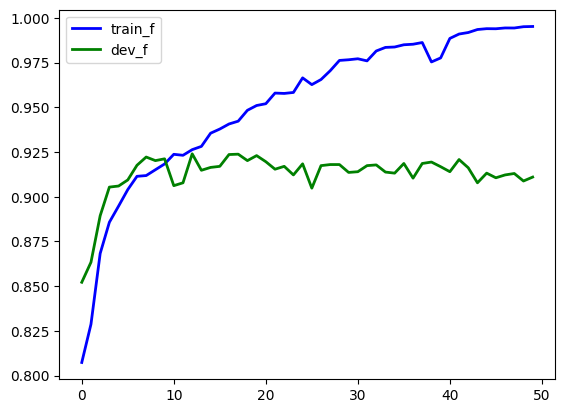

In [16]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd

# Data
df = pd.DataFrame({'epochs': range(0,len(train_f)), 
                  'train_f': train_f, 
                   'dev_f': dev_f})
 
# multiple line plot
plt.plot('epochs', 'train_f', data=df, color='blue', linewidth=2)
plt.plot('epochs', 'dev_f', data=df, color='green', linewidth=2)
plt.legend()
plt.show()


In [17]:
%load_ext tensorboard

In [18]:
tagger = torch.load(OUTPUT_PATH)
tagger.eval()

BiLSTMTagger(
  (embeddings): Embedding(9135, 300)
  (lstm): LSTM(300, 256, bidirectional=True)
  (dropout_layer): Dropout(p=0.5, inplace=False)
  (hidden2tag): Linear(in_features=512, out_features=6, bias=True)
)

In [21]:
labels = label_field.vocab.itos[2:]
labels = sorted(labels, key=lambda x: x.split("-")[-1])
label_idxs = [label_field.vocab.stoi[l] for l in labels]

test(tagger, test_iter, BATCH_SIZE, labels = label_idxs, target_names = labels)

              precision    recall  f1-score   support

        B-AC       0.80      0.59      0.68       270
        I-LF       0.66      0.82      0.73       288
        B-LF       0.62      0.55      0.58       150
         B-O       0.96      0.96      0.96      4292

    accuracy                           0.92      5000
   macro avg       0.76      0.73      0.74      5000
weighted avg       0.92      0.92      0.92      5000



In [20]:
from colorama import Back, Style

def vizu(words, output, truth):
    if isinstance(output, torch.Tensor):
        output = output.squeeze().tolist()
    col = {0: Back.BLACK, 1: Back.RED, 2: Back.GREEN, 3: Back.BLUE, 4: Back.MAGENTA}
    colors1 = [col[i] for i in output]
    colors2 = [col[i] for i in truth]
    words = [word.replace("Ġ", "") for word in words]
    print(Style.RESET_ALL + "Output:")
    for i, word in enumerate(words):
        print(colors1[i] + word, end=" ")
    print(Style.RESET_ALL + "\nTruth:")
    for i, word in enumerate(words):
        print(colors2[i] + word, end=" ")